# Aprendizaje por refuerzo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

class RacingEnvironment:
    def __init__(self, track):
        self.track = track  # Matriz de la pista (0: libre, 1: pared, 2: meta, 3: inicio)
        self.reset()

    def reset(self):
        """
        Devuelve el coche a la posición de inicio y neutraliza la velocidad
        """
        # Elegimos una posición inicial entre los disponibles en la matriz
        start_positions_from_track = list(zip(*np.where(self.track == 3)))
        self.position = random.choice(start_positions_from_track)
        while self.track[self.position] == 1:  # Verificamos que no sea un obstáculo
            self.position = random.choice(start_positions_from_track)
        self.velocity = (0, 0)  # Ponemos velocidad nula y ya podemos reiniciar
        return self.position, self.velocity


    def step(self, action):
        """
        Ejecuta una acción y retorna (estado_siguiente, recompensa, terminado)
        """
        # Actualizamos la velocidad con la acción (siempre menor que 5)
        new_velocity = (
            max(-4, min(self.velocity[0] + action[0], 4)),
            max(-4, min(self.velocity[1] + action[1], 4))
        )

        # Calculamos la nueva posición en base a la velocidad actualizada
        new_position = (
            self.position[0] + new_velocity[0],
            self.position[1] + new_velocity[1]
        )

        # Verificamos si el coche ha chocado con los bordes o se ha salido de la pista
        if not self.is_within_bounds(new_position) or self.track[new_position] == 1:
            #print(f"Colisión detectada en {new_position}. Reiniciando...")
            start_positions_from_track = list(zip(*np.where(self.track == 3)))
            self.position = random.choice(start_positions_from_track)
            self.velocity = (0, 0)
            return (self.position, self.velocity), -10, False

        # Verificamos si ha llegado a la meta o su trayectoria está de camino
        if self.track[new_position] == 2:
            print(f"Meta alcanzada en {new_position}.")
            return (new_position, new_velocity), 100, True


        # Actualización de estado
        self.position = new_position
        self.velocity = new_velocity
        #print(f"Nueva posición: {self.position}, nueva velocidad: {self.velocity}")
        return (self.position, self.velocity), -1, False

    def is_within_bounds(self, position):
        rows, cols = self.track.shape
        return 0 <= position[0] < rows and 0 <= position[1] < cols


def monte_carlo_control(env, episodes=1000, gamma=0.9, max_steps=10000):
    """Control Monte Carlo para calcular la política óptima."""
    # Inicializamos los valores y las políticas como diccionarios vacíos
    Q = {}  # Valores de estado-acción
    returns = {}  # Para almacenar retornos promedio
    
    # Espacio de acciones: combinaciones de cambios de velocidad (dx, dy)
    actions = [(dx, dy) for dx in [1, -1, 0] for dy in [-1, 0, 1]]       
    
    steps_per_episode = []
    logged_indexes = [int(episodes*0.9), int(episodes*0.94), int(episodes*0.97), int(0.98*episodes)]
    logs = []
    
    for episode in range(episodes):
        state, velocity = env.reset()
        episode_log = []
        print(f"Comenzando episodio {episode + 1}...")

        step_count = 0  # Contador de pasos en el episodio
        while True:
            # Ponemos un límite al número de pasos en caso de que el coche no consiga encontrar la meta
            step_count += 1
            if step_count > max_steps:
                print(f"Episodio {episode + 1} terminado por superar el número máximo de pasos.")
                break

            valid_actions = [
               action for action in actions if env.is_within_bounds((int(state[0] + action[0]), int(state[1] + action[1]))) 
               and env.track[int(state[0] + action[0]), int(state[1] + action[1])] != 1
            ]

            epsilon = max(0.15, 1 - episode / episodes)  # Según pasan los episodios se supone que ha aprendido, luego quitaremos posibilidad de exploración
            action = epsilon_greedy(Q, state, valid_actions if valid_actions else actions, epsilon)


            # Realizar la acción
            (next_position, next_velocity), reward, done = env.step(action)
            #print(f"Estado actual: {state}, Acción: {action}, Recompensa: {reward}, Terminado: {done}")

            episode_log.append((state, action, reward))

            if done:
                print(f"Episodio {episode + 1} terminado. Número de pasos requeridos {step_count}")
                break

            state = next_position
        if episode in logged_indexes:
            logs.append([log[0] for log in episode_log])
            
        steps_per_episode.append(step_count)


        # Actualizamos los valores de Q con el retorno actual
        G = 0
        for t in reversed(range(len(episode_log))):
            state, action, reward = episode_log[t]
            G = gamma * G + reward

            if not any([(state == x[0] and action == x[1]) for x in episode_log[:t]]):
                if (state, action) not in returns:
                    returns[(state, action)] = []
                returns[(state, action)].append(G)
                Q[(state, action)] = np.mean(returns[(state, action)])

    # Derivamos la política optima
    policy = {}
    for state_action, value in Q.items():
        state, action = state_action
        if state not in policy or Q[(state, action)] > Q[(state, policy[state])]:
            policy[state] = action

    return policy, steps_per_episode, logs

In [2]:
def epsilon_greedy(Q, state, actions, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(actions)  # Exploramos nuevas posibilidades aleatoriamente
    else:
        # Elegimos la mejor acción posible en base a lo que ya hemos aprendido
        q_values = [Q.get((state, action), 0) for action in actions]
        max_q = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
        return random.choice(best_actions)


In [3]:
def plot_policy(policy, track):
    """Graficar la política sobre la pista."""
    plt.figure(figsize=(10, 10))
    for state, action in policy.items():
        plt.quiver(state[1], state[0], action[1], -action[0], angles='xy', scale_units='xy', scale=1, color='blue')

    plt.imshow(track, cmap="gray")
    plt.title("Política Óptima")
    plt.show()

In [4]:
def plot_steps_per_episode(steps_per_episode, window_size=20):
    # Utilizamos un promedio móvil con ventanas para visualizar mejor la tendencia de aprendizaje ya que no es muy legible la gráfica sino.
    smoothed_steps = pd.Series(steps_per_episode).rolling(window=window_size).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(steps_per_episode, alpha=0.3, label="Pasos por episodio (sin suavizar)")
    plt.plot(smoothed_steps, color="red", label=f"Promedio móvil (window={window_size})")
    plt.yscale("log")  # Escala logarítmica para eje Y
    plt.xlabel("Episodio")
    plt.ylabel("Número de pasos")
    plt.title("Evolución del número de pasos por episodio (suavizado)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

# Track 1

Comenzando episodio 1...
Meta alcanzada en (4, 18).
Episodio 1 terminado. Número de pasos requeridos 1008
Comenzando episodio 2...
Meta alcanzada en (7, 18).
Episodio 2 terminado. Número de pasos requeridos 1856
Comenzando episodio 3...
Meta alcanzada en (4, 18).
Episodio 3 terminado. Número de pasos requeridos 163
Comenzando episodio 4...
Meta alcanzada en (8, 17).
Episodio 4 terminado. Número de pasos requeridos 255
Comenzando episodio 5...
Meta alcanzada en (4, 17).
Episodio 5 terminado. Número de pasos requeridos 1117
Comenzando episodio 6...
Meta alcanzada en (4, 18).
Episodio 6 terminado. Número de pasos requeridos 2907
Comenzando episodio 7...
Meta alcanzada en (4, 17).
Episodio 7 terminado. Número de pasos requeridos 1970
Comenzando episodio 8...
Meta alcanzada en (5, 17).
Episodio 8 terminado. Número de pasos requeridos 10462
Comenzando episodio 9...
Meta alcanzada en (4, 19).
Episodio 9 terminado. Número de pasos requeridos 6996
Comenzando episodio 10...
Meta alcanzada en (6,

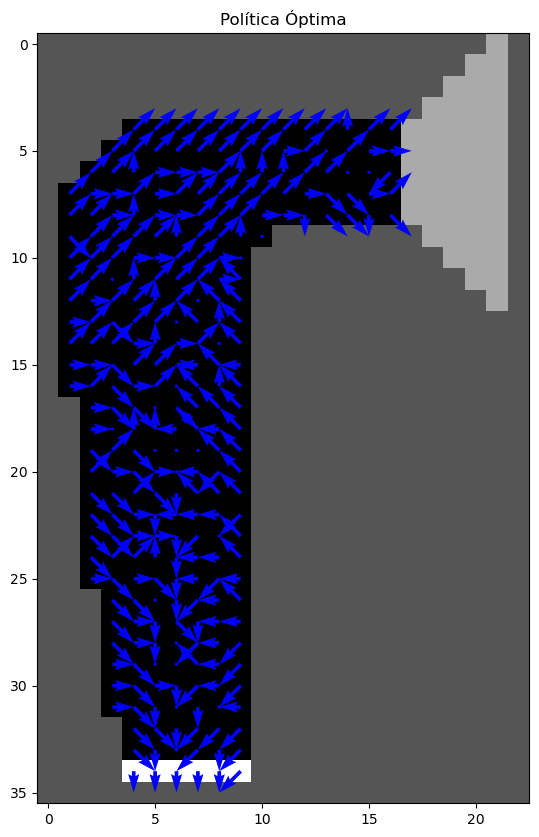

In [6]:
if __name__ == "__main__":
    track_1 = pd.read_csv("track1.csv").to_numpy()
    env_1 = RacingEnvironment(track_1)
    policy_1, steps_per_episode_1, log = monte_carlo_control(env_1, episodes=1000, max_steps=2000000)
    plot_policy(policy_1, track_1)

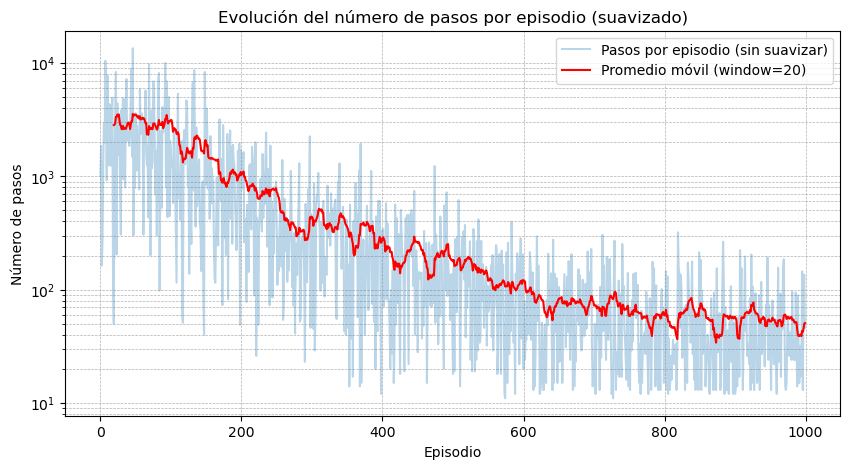

In [7]:
plot_steps_per_episode(steps_per_episode_1)

# Track 2

Comenzando episodio 1...
Meta alcanzada en (3, 34).
Episodio 1 terminado. Número de pasos requeridos 580
Comenzando episodio 2...
Meta alcanzada en (6, 35).
Episodio 2 terminado. Número de pasos requeridos 37
Comenzando episodio 3...
Meta alcanzada en (7, 35).
Episodio 3 terminado. Número de pasos requeridos 742
Comenzando episodio 4...
Meta alcanzada en (5, 35).
Episodio 4 terminado. Número de pasos requeridos 292
Comenzando episodio 5...
Meta alcanzada en (3, 34).
Episodio 5 terminado. Número de pasos requeridos 109
Comenzando episodio 6...
Meta alcanzada en (3, 34).
Episodio 6 terminado. Número de pasos requeridos 632
Comenzando episodio 7...
Meta alcanzada en (3, 33).
Episodio 7 terminado. Número de pasos requeridos 877
Comenzando episodio 8...
Meta alcanzada en (6, 32).
Episodio 8 terminado. Número de pasos requeridos 47
Comenzando episodio 9...
Meta alcanzada en (9, 33).
Episodio 9 terminado. Número de pasos requeridos 1399
Comenzando episodio 10...
Meta alcanzada en (5, 35).
Epi

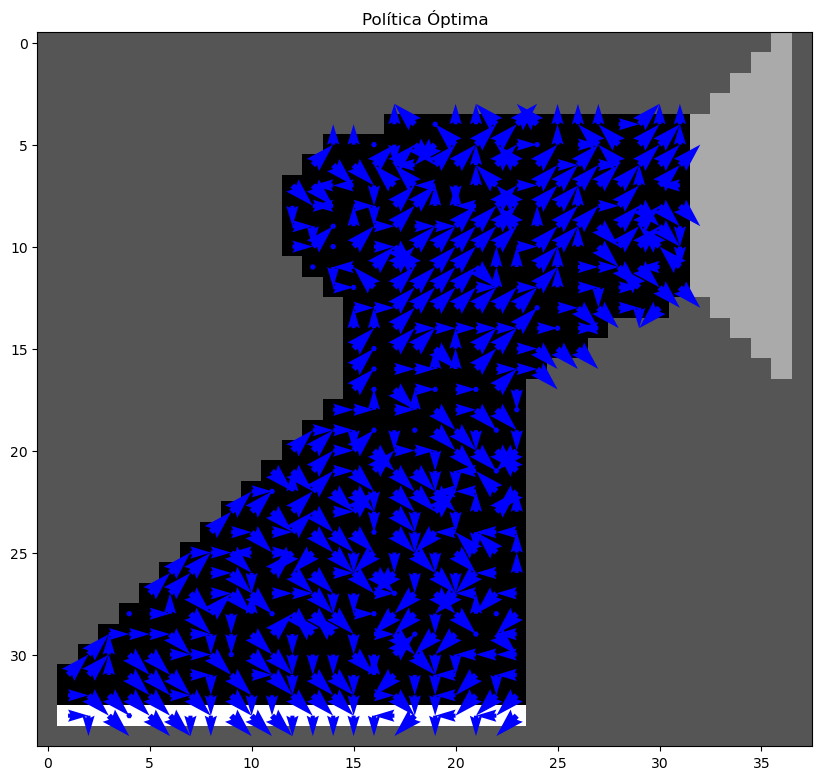

In [9]:
if __name__ == "__main__":
    track_2 = pd.read_csv("track2.csv").to_numpy()
    env_2 = RacingEnvironment(track_2)
    policy_2, steps_per_episode_2, log2 = monte_carlo_control(env_2, episodes=1000, max_steps=2000000)
    plot_policy(policy_2, track_2)

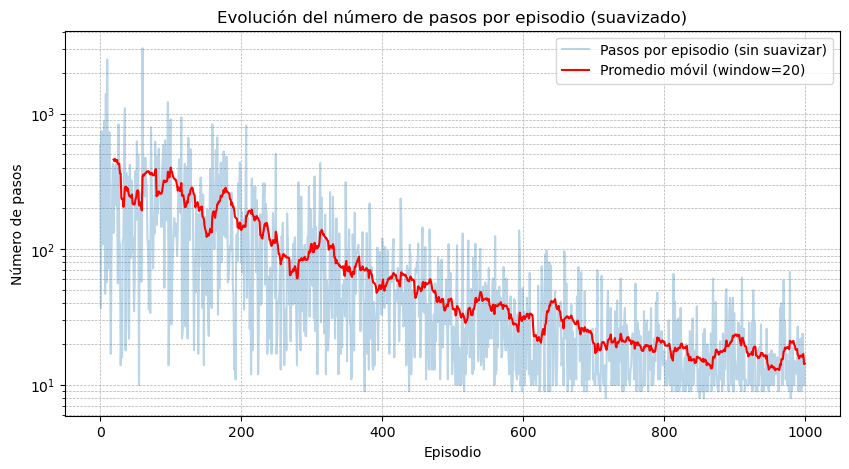

In [10]:
plot_steps_per_episode(steps_per_episode_2)

# Visualización con gifs

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import os
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def crear_gifs_por_log(track, logs, output_dir="gifs_logs"):
    """
    Crea un GIF para cada log de simulación donde un coche sigue el recorrido sobre el circuito.
    
    Parámetros:
    - track: Matriz que representa el circuito.
    - logs: Lista de listas, donde cada sublista es la secuencia de posiciones de un episodio.
    - output_dir: Directorio donde se guardarán los GIFs generados.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Cargamos la imagen del coche
    car_img = mpimg.imread("coche_IO.png")  

    for idx, log in enumerate(logs):
        fig, ax = plt.subplots(figsize=(8, 8))
        images = []

        # Dibujar el circuito
        ax.imshow(track, cmap="gray_r")
        ax.set_title(f"Simulación {idx + 1}")
        ax.axis("off")

        for step in log:
            ax.imshow(track, cmap="gray_r")
            car_icon = OffsetImage(car_img, zoom=0.05)  # Creamos una nueva instancia para cada log
            ab = AnnotationBbox(car_icon, (step[1], step[0]), frameon=False)
            ax.add_artist(ab)
            plt.draw()
            plt.pause(0.05)

            # Guardamos el frame
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)

            ab.remove()  # Eliminar el icono del coche antes de añadir el siguiente

        # Guardamos el gif en el directorio 
        gif_path = os.path.join(output_dir, f"simulacion_{idx + 1}.gif")
        imageio.mimsave(gif_path, images, fps=10)
        plt.close(fig)

    print(f"GIFs guardados en el directorio: {output_dir}")



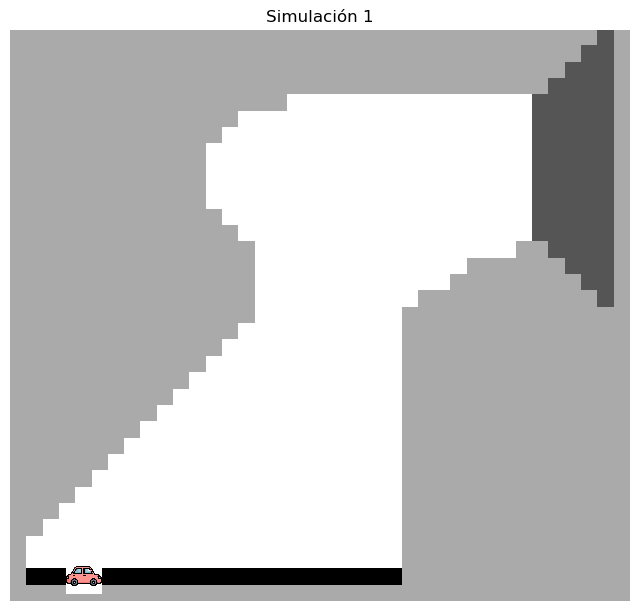

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

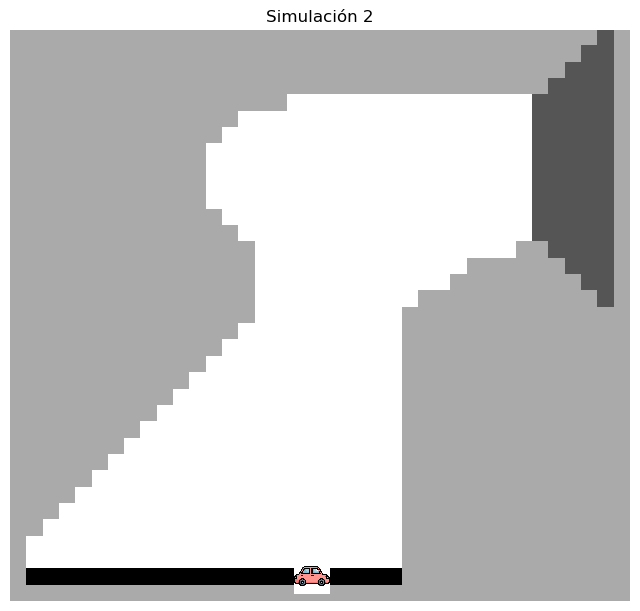

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

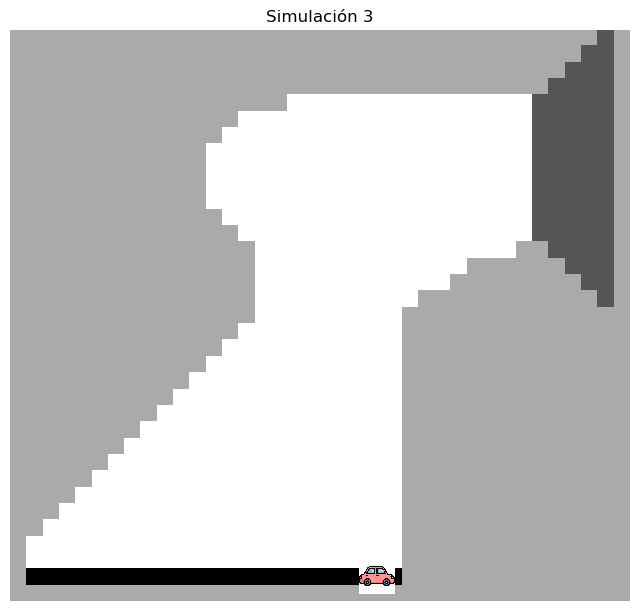

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

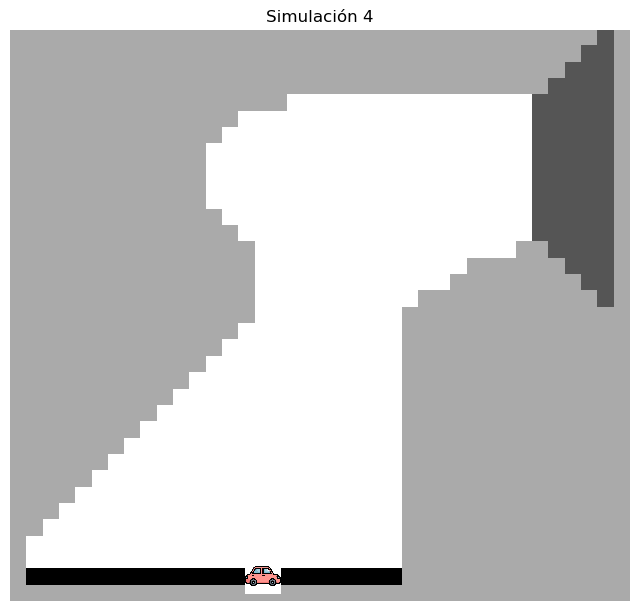

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

GIFs guardados en el directorio: gifs_logs_coche_track2


In [14]:
crear_gifs_por_log(track_2, log2, output_dir="gifs_logs_coche_track2")

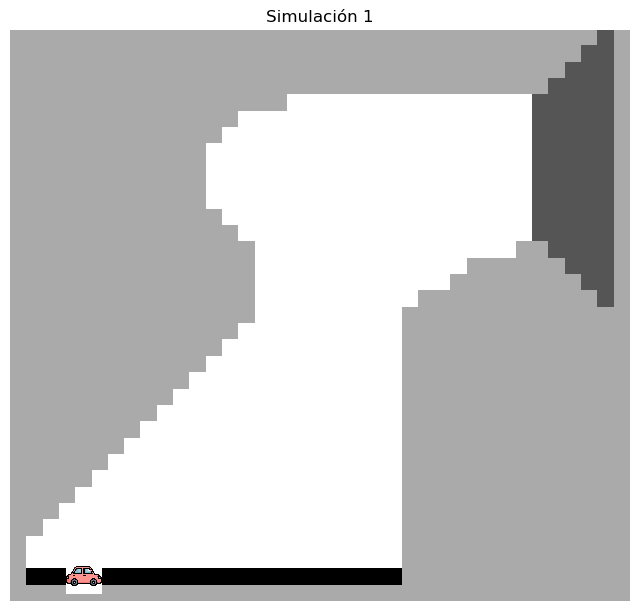

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

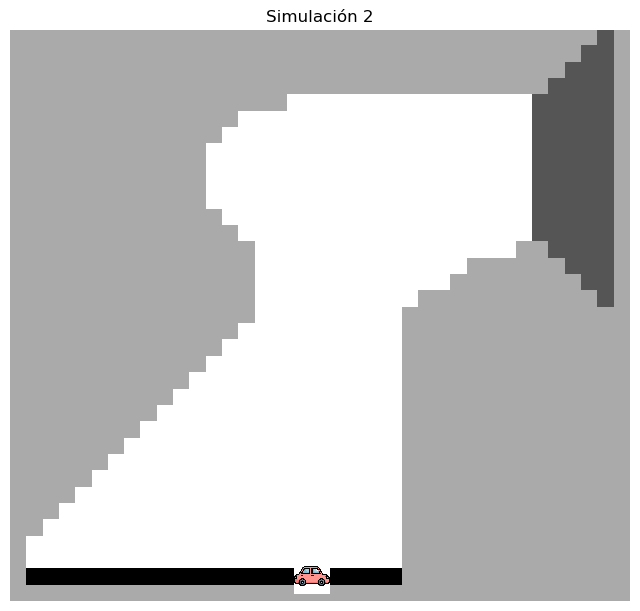

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

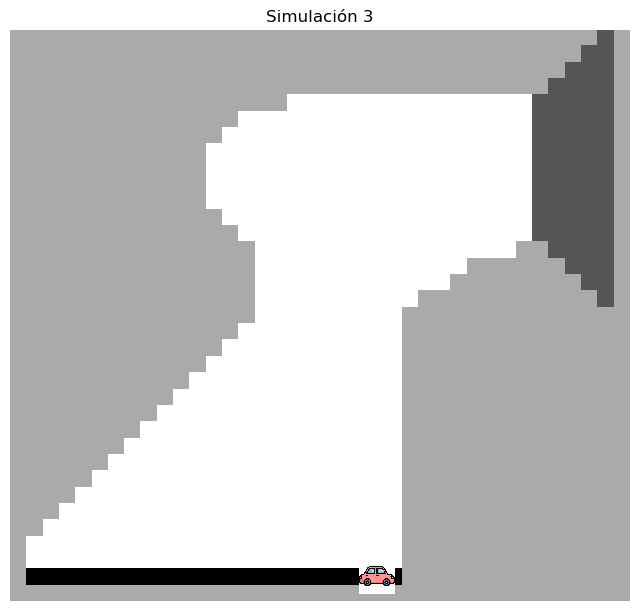

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

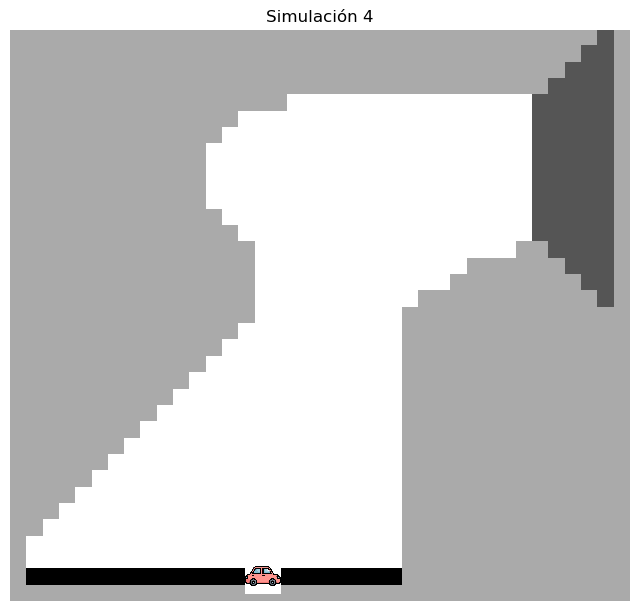

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

GIFs guardados en el directorio: gifs_logs_coche_track1


In [15]:
crear_gifs_por_log(track_2, log2, output_dir="gifs_logs_coche_track1")